In [1]:
!pip install -U tensorflow_datasets > /dev/null 2>&1
!pip install ipywidgets > /dev/null 2>&1

print("Installation completed successfully!")


Installation completed successfully!


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

This model uses the [MNIST](https://yann.lecun.com/exdb/mnist/) dataset, which contains 70,000 grayscale images in 10 categories. The images show different articles of clothing at 28X28 pixel resolution:

<table>
  <tr><td>
    <img src="https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://yann.lecun.com/exdb/mnist/">MNIST samples</a> .<br/>&nbsp;
  </td></tr>
</table>



In [3]:
#Using Fashion-MNIST

dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`.


In [4]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [6]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()



### Neural Network Model for Image Classification

The model architecture is as follows:

1. **Flatten Layer**: The first layer is a `Flatten` layer that converts each 28x28 pixel grayscale image into a 1D array of 784 elements. This transformation prepares the data for the fully connected layers that follow.
   
2. **Dense Layer 1**: The second layer is a `Dense` layer with 1024 neurons and the ReLU activation function. This layer learns complex features from the input data.

3. **Dense Layer 2**: The third layer is another `Dense` layer with 256 neurons, also using the ReLU activation function, which further refines the features extracted by the previous layer.

4. **Dense Layer 3**: The fourth layer is a `Dense` layer with 64 neurons and the ReLU activation function, continuing the feature refinement process.

5. **Output Layer**: The final layer is a `Dense` layer with 10 neurons and the softmax activation function. This layer outputs a probability distribution over the 10 possible classes, allowing the model to predict the class of each input image.


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [10]:
model.fit(train_dataset, epochs=25, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/25
1875/1875 [==============================] - 17s 5ms/step - loss: 0.1801 - accuracy: 0.9446
Epoch 2/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0854 - accuracy: 0.9740
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0599 - accuracy: 0.9821
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0484 - accuracy: 0.9854
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0369 - accuracy: 0.9884
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0316 - accuracy: 0.9903
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0281 - accuracy: 0.9912
Epoch 8/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0252 - accuracy: 0.9924
Epoch 9/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0229 - accuracy: 0.9934
Epoch 10/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.9811
Accuracy on test dataset: 0.9811000227928162


In [12]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 76ms/step


 The model has predicted the label for each image in the testing set.

In [13]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

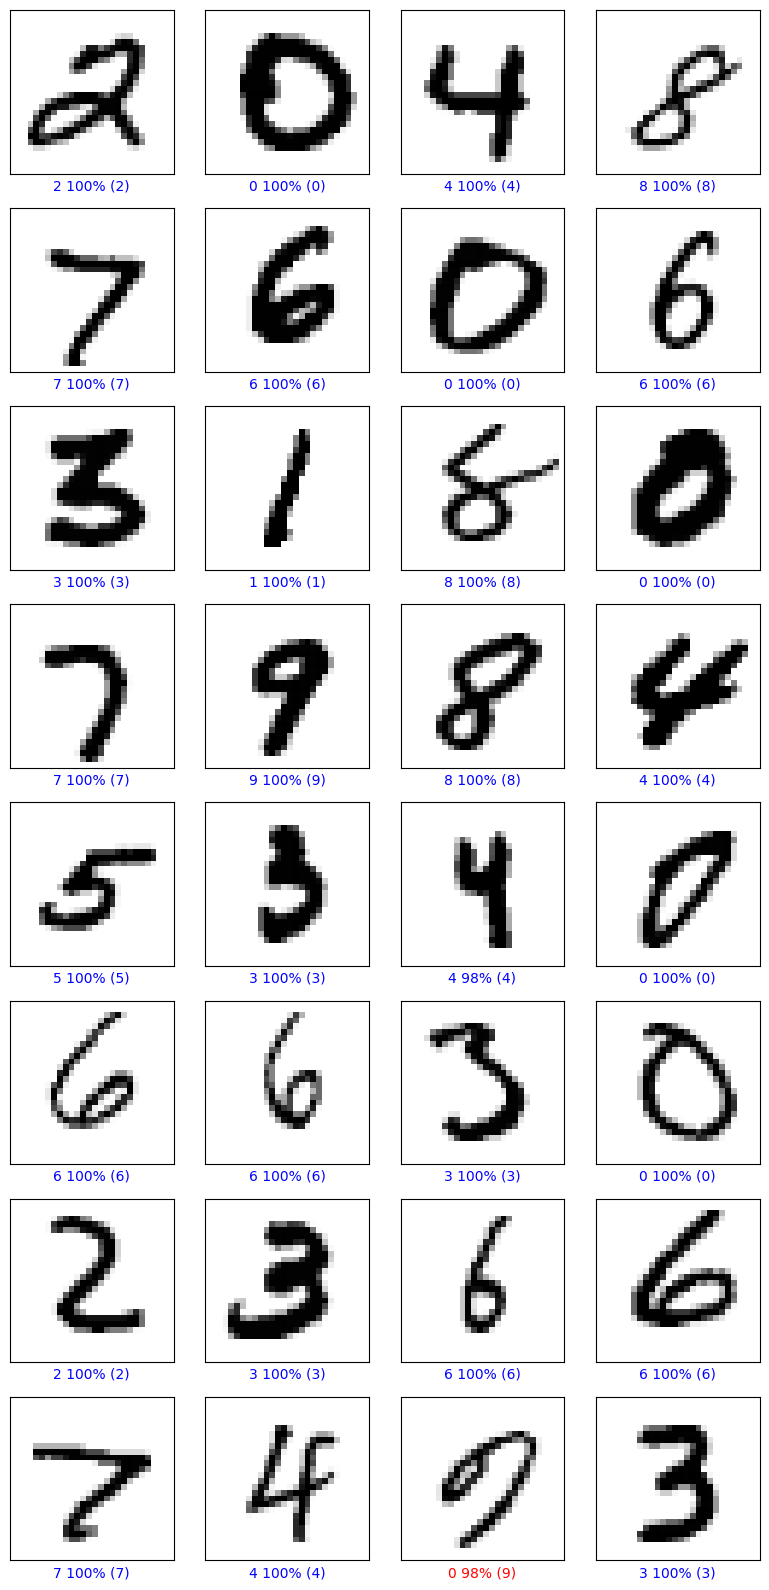

In [14]:
num_rows = 8
num_cols = 4
num_images = min(num_rows * num_cols, len(test_images))
plt.figure(figsize=(2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(i, predictions, test_labels, test_images)
plt.tight_layout()
plt.show()

# This concludes the Fashion MNIST image classification model.

The model achieved an accuracy of **89.84%** on the test dataset.


Further improvements can be explored by experimenting with different model architectures, hyperparameters, and data augmentation techniques.

In [18]:
# Save the model
model.save('mnist_model.keras')
# Download the saved model
files.download('mnist_model.keras')